In [1]:
#to suppress sklearn package warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [4]:
#downloading MNIST dataset provided by sklearn package
mnist_data = fetch_mldata('MNIST original')
X,y = mnist_data["data"], mnist_data["target"]
print(mnist_data.keys())
print(X.shape,y.shape)

dict_keys(['DESCR', 'COL_NAMES', 'target', 'data'])
(70000, 784) (70000,)


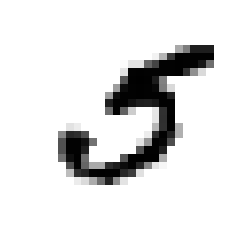

5.0


In [5]:
#matplotlib's imshow() can be used to display an image i.e data on a 2D regular raster
%matplotlib inline
some_digit = X[36000] #randomly picking a digit
some_digit_im = some_digit.reshape(28,28) #reshaping the pixel intensity vector into a 28*28 array
# interpolation="nearest" - displays an image without trying to interpolate between pixels 
# if the display resolution is not the same as image resolution
# It will result an image in which pixels are displayed as a square of multiple pixels.
plt.imshow(some_digit_im, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
print(y[36000])

In [6]:
#splitting dataset into 60000 training points and 10000 test points
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#shuffling the training dataset randomly so it would work well during CV
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
######################### Training a binary classifier -> 5-detector i.e to identify only digit 5 ######################

In [14]:
#changing the labels to indicate True = '5' and False=anything else
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
#initiating and fitting a SGD classifier model
#setting random state parameter to get reproducible results
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

# Implementing Stratified kfold CV

In [18]:
#initiating StratifiedKFold splits. Splitting the entire training set (60k points) into 3 folds
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

In [19]:
#train_index = 2 folds, test_index = 1 fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #copying the SGD classifier model
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    #fitting SGD classifier on training folds
    clone_clf.fit(X_train_folds, y_train_folds)
    #predicting the testing fold
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred)) #accuracy i.e number of correctly classified points/total points

0.95665
0.95925
0.9662


# Computing confusion matrices based on kfold CV

In [20]:
#cross_val_precict performs k-fold cross-validation and returns the predictions made on each fold.(3 folds = 3*20000 = 60000 predictions)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
confusion_matrix(y_train_5, y_train_pred)

array([[53377,  1202],
       [ 1156,  4265]])

In [22]:
#computing precision and recall on the training sample predictions
pscore = precision_score(y_train_5, y_train_pred)
rscore = recall_score(y_train_5,y_train_pred)
print(pscore,rscore)

0.7801353576001463 0.7867552112156428


# Plotting Precision Recall curve of predictions on training dataset

In [23]:
#this function plots the precision-recall curve over a given range of threholds
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

In [24]:
#getting the prediction scores from the SGDClassifier instead of predicted labels
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

(60000, 2)

In [30]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [31]:
#precision_recall_curve() returns precisions and recalls using a range of thresholds of scores
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

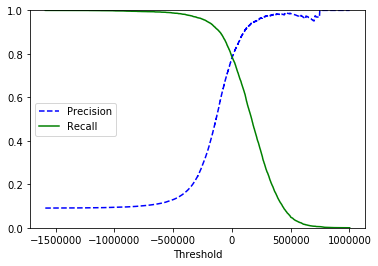

In [32]:
plot_precision_recall(precisions, recalls, thresholds)
plt.show()

# Plotting the ROC curve on predictions on training dataset

In [33]:
#this function plots the ROC curve given the set of fprs and tprs for a given range of thresholds
def plot_roc_curve(fpr, tpr, label = None):
    #plotting the ROC curve
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    #plotting the dotted straight line -> random classifier
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [34]:
#roc_curve() returns the fpr and tpr using a range of thresholds of scores
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

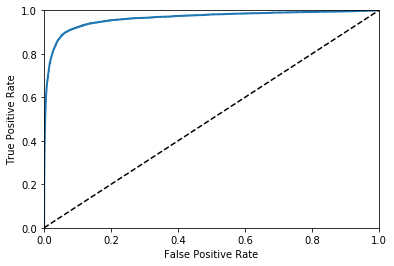

In [35]:
#plotting the ROC curve
plot_roc_curve(fpr, tpr, thresholds)
plt.show()

In [36]:
print(roc_auc_score(y_train_5,y_scores))

0.9634117752624871


# Training a RandomForestClassifier to compare with the SGD Classifier

In [37]:
#initiating the random forest classifier
forest_clf = RandomForestClassifier(random_state=42)

In [38]:
#fitting the data and retrieving the prediction probabilities for each instance for each class using 3-fold CV
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

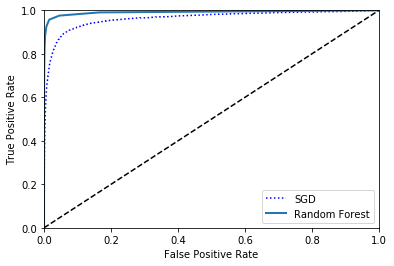

In [39]:
#plotting ROC curve using the probabilities of positive class(i.e a "5")
y_scores_forest = y_probs_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD") #plotting SGD ROC
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
print(roc_auc_score(y_train_5,y_scores_forest))

0.9915570615272493


# Multi-class SGD classifier with OVA (one versus all) strategy

In [41]:
# OVA(One-versus-all) - a binary classifier for each class (selected class = 1, all other classes = 0) => n+1 classifiers where n = num of categories
# OVO(One-versus-other) - a binary classifier for every pair of class levels => n(n-1)/2 classifiers where n= num of categories

In [42]:
#fitting SGD classifier on the full training dataset => multiclass classification
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [43]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Implementing OVO SGD classifier using OneVsOneClassifier class

In [46]:
# Create an instance of OneVsOneClassifier and pass a binary classifier to its constructor

In [45]:
#creating an instance of ovo class
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
#fitting the entire training dataset
ovo_clf.fit(X_train, y_train)
print(len(ovo_clf.estimators_))

45


In [47]:
#evaluating using CV
cross_val_score(sgd_clf,X_train, y_train, cv=3,scoring="accuracy")

array([0.87672466, 0.83679184, 0.87563134])

In [48]:
#fitting the standardized (Scaled) training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90881824, 0.9079954 , 0.91248687])

# Error Analysis

In [50]:
# computing confusion matrix on the scaled training dataset
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    3,   22,   10,   11,   46,   43,    8,   40,    3],
       [   1, 6504,   47,   25,    5,   43,    5,    9,   92,   11],
       [  55,   34, 5339,   92,   85,   24,  103,   55,  155,   16],
       [  51,   39,  141, 5323,    2,  244,   34,   59,  142,   96],
       [  21,   30,   30,    7, 5365,   11,   53,   37,   88,  200],
       [  71,   40,   37,  190,   75, 4578,  108,   24,  203,   95],
       [  37,   29,   44,    2,   45,   85, 5624,    6,   46,    0],
       [  24,   21,   76,   26,   56,   11,    7, 5820,   15,  209],
       [  49,  164,   70,  153,   16,  155,   57,   22, 5034,  131],
       [  39,   35,   26,   89,  157,   36,    2,  218,   85, 5262]])

In [51]:
# this function plots a confusion matrix using matplotlib's matshow()
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

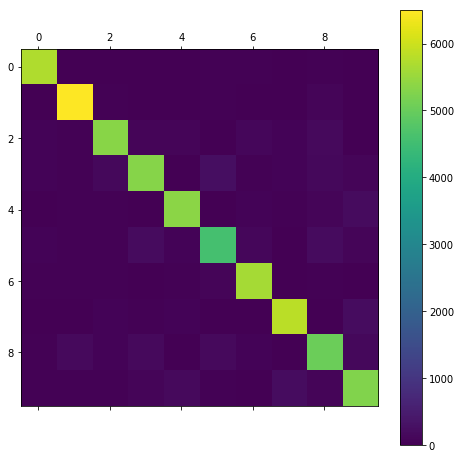

In [55]:
plot_confusion_matrix(conf_mx)

In [57]:
# normalizing confusion matrix for balancing different class label counts
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

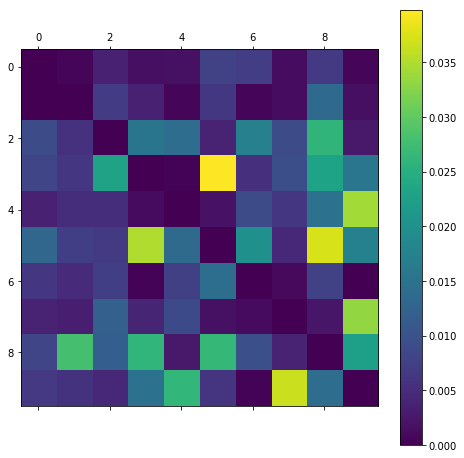

In [59]:
# filling diagonal elements i.e. correct predictions to be zero
np.fill_diagonal(norm_conf_mx,0)
plot_confusion_matrix(norm_conf_mx)

In [66]:
# this function plots digits
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances] # reshaping images
    n_rows = (len(instances) - 1)//images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size*n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row:(row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages,axis = 1))
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

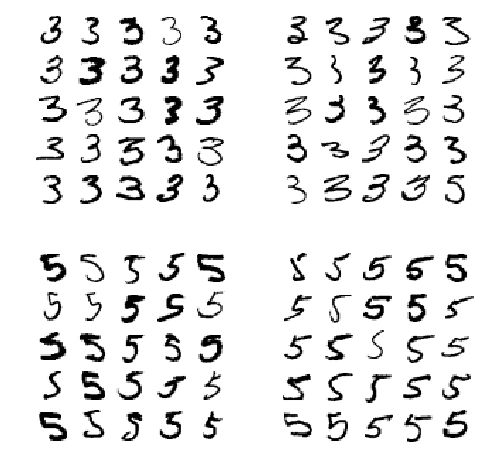

In [67]:
# analyzing individual errors
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # TPs for digit 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # digit 3 falsely predicted as 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # digit 5 falsely predicted as 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # TPs for digit 5
# plotting 25 points in each category
plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

# Multilabel classification

In [68]:
y_train_large = (y_train >= 7) # first label indicating if the digit is large (7, 8 or 9)
y_train_odd = (y_train % 2 == 1) # second label indicating if the digit is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

In [69]:
# initializing Knn classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')